In [1]:
import numpy as np
import pandas as pd
df=pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
data = df.sample(frac=0.90, random_state=786)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (691, 9)
Unseen Data For Predictions: (77, 9)


In [3]:
from pycaret.classification import *

**Missing Values**: There are no missing values in the data. However, we still need imputers in our pipeline just in case the new unseen data has missing values (not applicable in this case). When you execute the setup() function, imputers are created and stored in the pipeline automatically. By default, it uses a mean imputer for numeric values and a constant imputer for categorical. This can be changed using the numeric_imputation and categorical_imputation parameters in setup().

**Multicollinearity**: We will remove multi-collinearity by using the remove_multicollinearity and multicollinearity_threshold parameters in setup.

**Data Scale / Range**: Notice how the scale / range of numeric features are different. We will deal with this problem by using the normalize parameter in setup.

**Distribution of Feature Space**: Numeric features are not normally distributed. This may cause problems for algorithms that assume normal or approximate normal distributions of the data. Examples include Logistic Regression, Linear Discriminant Analysis (LDA) and Naive Bayes. We will deal with this problem by using the transformation parameter in setup

In [5]:
exp_clf102 = setup(data = data, target = 'Outcome', session_id=123,
                  normalize = True, 
                  transformation = True, 
                  ignore_low_variance = True,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95)

,Description,Value
0,session_id,123
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(691, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [6]:
top3 = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7723,0.8012,0.5500,0.7131,0.6169,0.4594,0.4697,0.2020
catboost,CatBoost Classifier,0.7722,0.8160,0.5680,0.7003,0.6231,0.4635,0.4710,2.0460
gbc,Gradient Boosting Classifier,0.7619,0.8019,0.5809,0.6671,0.6183,0.4475,0.4514,0.0780
lightgbm,Light Gradient Boosting Machine,0.7578,0.7744,0.5559,0.6726,0.6066,0.4342,0.4397,0.0690
ada,Ada Boost Classifier,0.7577,0.7943,0.5625,0.6720,0.6099,0.4364,0.4419,0.0890
lr,Logistic Regression,0.7559,0.8175,0.5316,0.6738,0.5924,0.4223,0.4293,0.6600
lda,Linear Discriminant Analysis,0.7538,0.8079,0.5250,0.6737,0.5874,0.4164,0.4245,0.0150
ridge,Ridge Classifier,0.7517,0.0000,0.5125,0.6756,0.5789,0.4083,0.4185,0.0130
et,Extra Trees Classifier,0.7474,0.7686,0.4816,0.6696,0.5586,0.3893,0.4002,0.1700
svm,SVM - Linear Kernel,0.7415,0.0000,0.5386,0.6330,0.5672,0.3924,0.4001,0.0160


In [7]:
print(top3)

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False), <catboost.core.CatBoostClassifier object at 0x0000023EA3A0A8E0>, GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                    

In [8]:
dt = create_model('dt', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7113,0.6974,0.6562,0.5526,0.6000,0.3768,0.3802
1,0.6495,0.6023,0.4545,0.4839,0.4687,0.2076,0.2078
2,0.7320,0.6941,0.5758,0.6129,0.5938,0.3940,0.3945
3,0.6667,0.6328,0.5312,0.5000,0.5152,0.2615,0.2618
4,0.7292,0.7109,0.6562,0.5833,0.6176,0.4091,0.4108
Mean,0.6977,0.6675,0.5748,0.5465,0.5591,0.3298,0.3310
SD,0.0336,0.0423,0.0770,0.0488,0.0573,0.0803,0.0810


In [9]:
rf = create_model('rf', round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.82,0.85,0.69,0.73,0.71,0.58,0.58
1,0.76,0.86,0.53,0.69,0.60,0.43,0.44
2,0.73,0.77,0.47,0.67,0.55,0.37,0.38
3,0.71,0.82,0.44,0.58,0.50,0.30,0.31
4,0.81,0.84,0.62,0.77,0.69,0.56,0.56
5,0.79,0.81,0.44,0.88,0.58,0.46,0.51
6,0.77,0.77,0.56,0.69,0.62,0.46,0.46
7,0.83,0.80,0.69,0.79,0.73,0.61,0.62
8,0.67,0.67,0.44,0.50,0.47,0.23,0.23
9,0.83,0.83,0.62,0.83,0.71,0.60,0.61


## Model Tunning

In [10]:
tuned_rf = tune_model(rf, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7755,0.8220,0.8125,0.6190,0.7027,0.5276,0.5402
1,0.7551,0.8548,0.7059,0.6316,0.6667,0.4741,0.4759
2,0.7551,0.7978,0.5882,0.6667,0.6250,0.4442,0.4462
3,0.7500,0.8262,0.6875,0.6111,0.6471,0.4545,0.4564
4,0.7500,0.8301,0.8125,0.5909,0.6842,0.4857,0.5026
5,0.7917,0.8672,0.6250,0.7143,0.6667,0.5161,0.5186
6,0.7500,0.8262,0.7500,0.6000,0.6667,0.4706,0.4781
7,0.8125,0.8281,0.7500,0.7059,0.7273,0.5846,0.5852
8,0.6458,0.7031,0.6875,0.4783,0.5641,0.2817,0.2949
9,0.8125,0.8555,0.6875,0.7333,0.7097,0.5714,0.5721


In [12]:
plot_model(tuned_rf, plot = 'parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,entropy
max_depth,4
max_features,log2
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0002
min_impurity_split,None


In [11]:
tuned_rf2 = tune_model(rf, optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7347,0.8314,0.8125,0.5652,0.6667,0.4579,0.4787
1,0.8163,0.8768,0.8824,0.6818,0.7692,0.6208,0.6351
2,0.7347,0.7941,0.5294,0.6429,0.5806,0.3893,0.3932
3,0.7292,0.8223,0.6250,0.5882,0.6061,0.4000,0.4004
4,0.7917,0.8379,0.8750,0.6364,0.7368,0.5714,0.5913
5,0.7917,0.8535,0.6250,0.7143,0.6667,0.5161,0.5186
6,0.7708,0.7988,0.8125,0.6190,0.7027,0.5217,0.5345
7,0.8125,0.8164,0.7500,0.7059,0.7273,0.5846,0.5852
8,0.6458,0.6973,0.6250,0.4762,0.5405,0.2609,0.2673
9,0.8125,0.8496,0.6875,0.7333,0.7097,0.5714,0.5721


In [13]:
plot_model(tuned_rf2, plot = 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,gini
max_depth,4
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0005
min_impurity_split,None


## Ensemble a Model
Ensembling is a common machine learning technique used to improve the performance of models (mostly tree based). There are various techniques for ensembling that we will cover in this section. These include Bagging and Boosting. We will use the ensemble_model() function in PyCaret which ensembles the trained base estimators using the method defined in the method parameter.

In [14]:
# lets create a simple decision tree model that we will use for ensembling 
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6735,0.6610,0.6250,0.5000,0.5556,0.3025,0.3072
1,0.7347,0.7142,0.6471,0.6111,0.6286,0.4225,0.4229
2,0.6531,0.5965,0.4118,0.5000,0.4516,0.2013,0.2034
3,0.7083,0.6562,0.5000,0.5714,0.5333,0.3226,0.3241
4,0.6875,0.6562,0.5625,0.5294,0.5455,0.3077,0.3080
5,0.5833,0.5625,0.5000,0.4000,0.4444,0.1176,0.1195
6,0.6875,0.6406,0.5000,0.5333,0.5161,0.2857,0.2860
7,0.7917,0.7656,0.6875,0.6875,0.6875,0.5312,0.5312
8,0.6250,0.5938,0.5000,0.4444,0.4706,0.1818,0.1826
9,0.7083,0.7188,0.7500,0.5455,0.6316,0.4000,0.4139


### Bagging

In [15]:
bagged_dt = ensemble_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7959,0.8116,0.6875,0.6875,0.6875,0.5360,0.5360
1,0.8163,0.8125,0.7647,0.7222,0.7429,0.6002,0.6008
2,0.6735,0.7436,0.2941,0.5556,0.3846,0.1901,0.2079
3,0.7083,0.7588,0.3125,0.6250,0.4167,0.2500,0.2767
4,0.8333,0.8379,0.6875,0.7857,0.7333,0.6129,0.6158
5,0.7083,0.7412,0.2500,0.6667,0.3636,0.2222,0.2673
6,0.8125,0.8008,0.6250,0.7692,0.6897,0.5574,0.5635
7,0.8333,0.8301,0.6875,0.7857,0.7333,0.6129,0.6158
8,0.6875,0.6357,0.3750,0.5455,0.4444,0.2373,0.2453
9,0.8542,0.8076,0.6875,0.8462,0.7586,0.6557,0.6630


In [16]:
# check the parameters of bagged_dt
print(bagged_dt)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=123,
 

### Boosting

In [17]:
boosted_dt = ensemble_model(dt, method = 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7347,0.7064,0.6250,0.5882,0.6061,0.4063,0.4068
1,0.6735,0.6121,0.4118,0.5385,0.4667,0.2374,0.2418
2,0.6122,0.5377,0.2941,0.4167,0.3448,0.0809,0.0834
3,0.6875,0.6406,0.5000,0.5333,0.5161,0.2857,0.2860
4,0.6875,0.6562,0.5625,0.5294,0.5455,0.3077,0.3080
5,0.5833,0.5938,0.6250,0.4167,0.5000,0.1667,0.1768
6,0.6875,0.6250,0.4375,0.5385,0.4828,0.2623,0.2652
7,0.7708,0.7500,0.6875,0.6471,0.6667,0.4923,0.4928
8,0.6458,0.6094,0.5000,0.4706,0.4848,0.2154,0.2156
9,0.7292,0.7188,0.6875,0.5789,0.6286,0.4179,0.4217


In [18]:
bagged_dt2 = ensemble_model(dt, n_estimators=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7755,0.8428,0.6875,0.6471,0.6667,0.4977,0.4982
1,0.8163,0.7932,0.7059,0.7500,0.7273,0.5890,0.5896
2,0.7143,0.7767,0.4118,0.6364,0.5000,0.3126,0.3271
3,0.7083,0.8057,0.4375,0.5833,0.5000,0.3000,0.3062
4,0.7917,0.8271,0.5625,0.7500,0.6429,0.5000,0.5103
5,0.7500,0.7676,0.3750,0.7500,0.5000,0.3571,0.3953
6,0.7708,0.8027,0.6250,0.6667,0.6452,0.4762,0.4767
7,0.7917,0.8193,0.6250,0.7143,0.6667,0.5161,0.5186
8,0.6250,0.6836,0.3125,0.4167,0.3571,0.1000,0.1021
9,0.8125,0.8369,0.6875,0.7333,0.7097,0.5714,0.5721


## Blending
Blending is another common technique for ensembling that can be used in PyCaret. It uses predictions from multiple models to generate a final set of predictions using voting / majority consensus from all of the models passed in the estimator_list parameter. The method parameter can be used to define the type of voting. When set to hard, it uses labels for majority rule voting. When set to soft it uses the sum of predicted probabilities instead of the label. Default value of method is set to auto which means it tries to use soft method and fall back to hard if the former is not supported. Let's see an example below:

In [19]:
# train individual models to blend
lightgbm = create_model('lightgbm', verbose = False)
dt = create_model('dt', verbose = False)
lr = create_model('lr', verbose = False)

In [20]:
# blend individual models
blend_soft = blend_models(estimator_list = [lightgbm, dt, lr], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7755,0.8011,0.6250,0.6667,0.6452,0.4812,0.4818
1,0.8163,0.8364,0.7647,0.7222,0.7429,0.6002,0.6008
2,0.6939,0.7463,0.4118,0.5833,0.4828,0.2744,0.2828
3,0.7083,0.7930,0.4375,0.5833,0.5000,0.3000,0.3062
4,0.7083,0.8066,0.5625,0.5625,0.5625,0.3438,0.3438
5,0.7500,0.7578,0.6250,0.6250,0.6250,0.4375,0.4375
6,0.7292,0.7852,0.5000,0.6154,0.5517,0.3607,0.3646
7,0.8125,0.8477,0.6875,0.7333,0.7097,0.5714,0.5721
8,0.6875,0.6621,0.5000,0.5333,0.5161,0.2857,0.2860
9,0.8125,0.8398,0.6875,0.7333,0.7097,0.5714,0.5721


In [21]:
# blend individual models
blend_hard = blend_models(estimator_list = [lightgbm, dt, lr], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8163,0.0000,0.6250,0.7692,0.6897,0.5612,0.5673
1,0.7755,0.0000,0.6471,0.6875,0.6667,0.4977,0.4982
2,0.6735,0.0000,0.3529,0.5455,0.4286,0.2144,0.2244
3,0.7500,0.0000,0.5000,0.6667,0.5714,0.4000,0.4082
4,0.7708,0.0000,0.6250,0.6667,0.6452,0.4762,0.4767
5,0.7500,0.0000,0.4375,0.7000,0.5385,0.3793,0.3990
6,0.7708,0.0000,0.5000,0.7273,0.5926,0.4407,0.4556
7,0.7917,0.0000,0.6875,0.6875,0.6875,0.5312,0.5312
8,0.6458,0.0000,0.3750,0.4615,0.4138,0.1639,0.1657
9,0.8542,0.0000,0.6875,0.8462,0.7586,0.6557,0.6630


In [22]:
# blend top3 models from compare_models
blender_top3 = blend_models(top3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7959,0.8617,0.6875,0.6875,0.6875,0.5360,0.5360
1,0.7959,0.8566,0.6471,0.7333,0.6875,0.5369,0.5392
2,0.7143,0.7721,0.4118,0.6364,0.5000,0.3126,0.3271
3,0.7500,0.8086,0.5625,0.6429,0.6000,0.4194,0.4213
4,0.7500,0.8574,0.5625,0.6429,0.6000,0.4194,0.4213
5,0.7500,0.8418,0.4375,0.7000,0.5385,0.3793,0.3990
6,0.8333,0.8105,0.6250,0.8333,0.7143,0.6000,0.6124
7,0.8125,0.8242,0.6875,0.7333,0.7097,0.5714,0.5721
8,0.6458,0.6875,0.3750,0.4615,0.4138,0.1639,0.1657
9,0.8750,0.8379,0.6875,0.9167,0.7857,0.7000,0.7144


In [23]:
print(blender_top3.estimators_)

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False), <catboost.core.CatBoostClassifier object at 0x0000023EA3D7BC40>, GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                    

## Stacking
Stacking is another popular technique for ensembling but is less commonly implemented due to practical difficulties. Stacking is an ensemble learning technique that combines multiple models via a meta-model. Another way to think about stacking is that multiple models are trained to predict the outcome and a meta-model is created that uses the predictions from those models as an input along with the original features. The implementation of stack_models() is based on Wolpert, D. H. (1992b). Stacked generalization.

In [24]:
stack_soft = stack_models(top3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7551,0.7860,0.5625,0.6429,0.6000,0.4247,0.4266
1,0.7347,0.8364,0.5882,0.6250,0.6061,0.4063,0.4068
2,0.6735,0.7610,0.3529,0.5455,0.4286,0.2144,0.2244
3,0.6875,0.7305,0.4375,0.5385,0.4828,0.2623,0.2652
4,0.8125,0.8789,0.6250,0.7692,0.6897,0.5574,0.5635
5,0.8125,0.8516,0.5625,0.8182,0.6667,0.5424,0.5608
6,0.8750,0.8828,0.6875,0.9167,0.7857,0.7000,0.7144
7,0.7708,0.8535,0.5625,0.6923,0.6207,0.4590,0.4641
8,0.6250,0.7148,0.3750,0.4286,0.4000,0.1290,0.1296
9,0.8542,0.8418,0.6875,0.8462,0.7586,0.6557,0.6630


In [25]:
xgboost = create_model('xgboost')
stack_soft2 = stack_models(top3, meta_model=xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8163,0.8693,0.6875,0.7333,0.7097,0.5756,0.5762
1,0.7347,0.7482,0.5882,0.6250,0.6061,0.4063,0.4068
2,0.7347,0.7463,0.5294,0.6429,0.5806,0.3893,0.3932
3,0.7292,0.8691,0.3750,0.6667,0.4800,0.3158,0.3397
4,0.7708,0.8301,0.6875,0.6471,0.6667,0.4923,0.4928
5,0.7708,0.8105,0.5000,0.7273,0.5926,0.4407,0.4556
6,0.7083,0.7598,0.4375,0.5833,0.5000,0.3000,0.3062
7,0.7917,0.8477,0.6250,0.7143,0.6667,0.5161,0.5186
8,0.7083,0.6855,0.4375,0.5833,0.5000,0.3000,0.3062
9,0.8125,0.8418,0.6875,0.7333,0.7097,0.5714,0.5721


## Model Calibration

In [26]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8163,0.8475,0.6875,0.7333,0.7097,0.5756,0.5762
1,0.7551,0.8594,0.5294,0.6923,0.6000,0.4280,0.4360
2,0.7347,0.7684,0.4706,0.6667,0.5517,0.3712,0.3825
3,0.7083,0.8164,0.4375,0.5833,0.5000,0.3000,0.3062
4,0.8125,0.8398,0.6250,0.7692,0.6897,0.5574,0.5635
5,0.7917,0.8096,0.4375,0.8750,0.5833,0.4643,0.5139
6,0.7708,0.7695,0.5625,0.6923,0.6207,0.4590,0.4641
7,0.8333,0.8008,0.6875,0.7857,0.7333,0.6129,0.6158
8,0.6667,0.6729,0.4375,0.5000,0.4667,0.2258,0.2269
9,0.8333,0.8281,0.6250,0.8333,0.7143,0.6000,0.6124


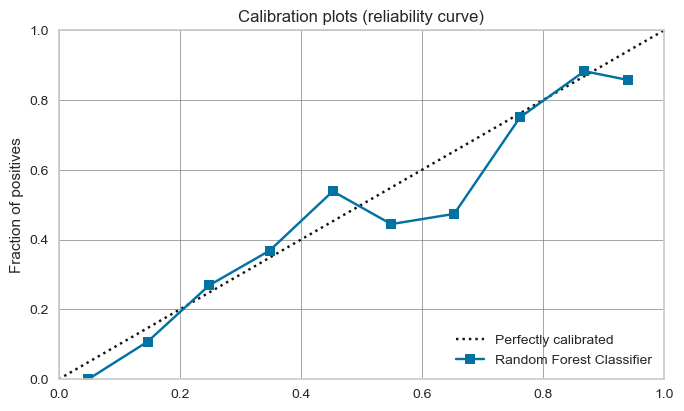

In [27]:
plot_model(rf, plot='calibration')

In [29]:
calibrated_rf = calibrate_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8163,0.8409,0.6875,0.7333,0.7097,0.5756,0.5762
1,0.8163,0.8621,0.6471,0.7857,0.7097,0.5772,0.5830
2,0.6735,0.7757,0.3529,0.5455,0.4286,0.2144,0.2244
3,0.7500,0.8125,0.4375,0.7000,0.5385,0.3793,0.3990
4,0.7500,0.8477,0.5000,0.6667,0.5714,0.4000,0.4082
5,0.7500,0.8008,0.3750,0.7500,0.5000,0.3571,0.3953
6,0.8333,0.7852,0.6250,0.8333,0.7143,0.6000,0.6124
7,0.7917,0.8457,0.6250,0.7143,0.6667,0.5161,0.5186
8,0.6875,0.6738,0.4375,0.5385,0.4828,0.2623,0.2652
9,0.8542,0.8301,0.6875,0.8462,0.7586,0.6557,0.6630


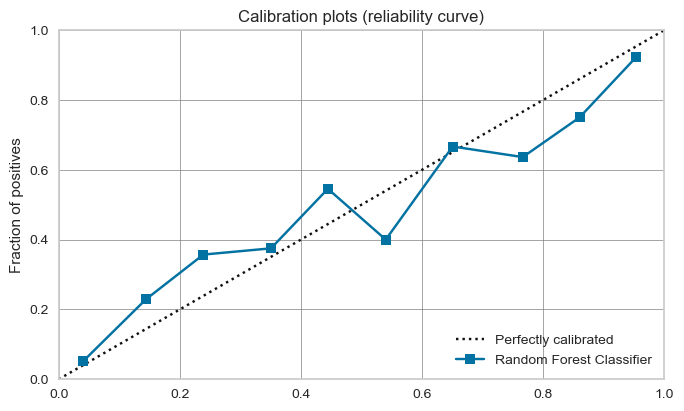

In [30]:
plot_model(calibrated_rf, plot='calibration')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8163,0.8409,0.6875,0.7333,0.7097,0.5756,0.5762
1,0.8163,0.8621,0.6471,0.7857,0.7097,0.5772,0.5830
2,0.6735,0.7757,0.3529,0.5455,0.4286,0.2144,0.2244
3,0.7500,0.8125,0.4375,0.7000,0.5385,0.3793,0.3990
4,0.7500,0.8477,0.5000,0.6667,0.5714,0.4000,0.4082
5,0.7500,0.8008,0.3750,0.7500,0.5000,0.3571,0.3953
6,0.8333,0.7852,0.6250,0.8333,0.7143,0.6000,0.6124
7,0.7917,0.8457,0.6250,0.7143,0.6667,0.5161,0.5186
8,0.6875,0.6738,0.4375,0.5385,0.4828,0.2623,0.2652
9,0.8542,0.8301,0.6875,0.8462,0.7586,0.6557,0.6630


In [32]:
calibrated_rf_isotonic = calibrate_model(rf, method = 'isotonic')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8367,0.8333,0.7500,0.7500,0.7500,0.6288,0.6288
1,0.7959,0.8511,0.6471,0.7333,0.6875,0.5369,0.5392
2,0.6939,0.7776,0.4118,0.5833,0.4828,0.2744,0.2828
3,0.7292,0.8145,0.4375,0.6364,0.5185,0.3390,0.3505
4,0.7917,0.8301,0.6875,0.6875,0.6875,0.5312,0.5312
5,0.7500,0.7852,0.4375,0.7000,0.5385,0.3793,0.3990
6,0.8542,0.7734,0.6875,0.8462,0.7586,0.6557,0.6630
7,0.8125,0.8398,0.6875,0.7333,0.7097,0.5714,0.5721
8,0.6875,0.6699,0.4375,0.5385,0.4828,0.2623,0.2652
9,0.8542,0.8281,0.6875,0.8462,0.7586,0.6557,0.6630


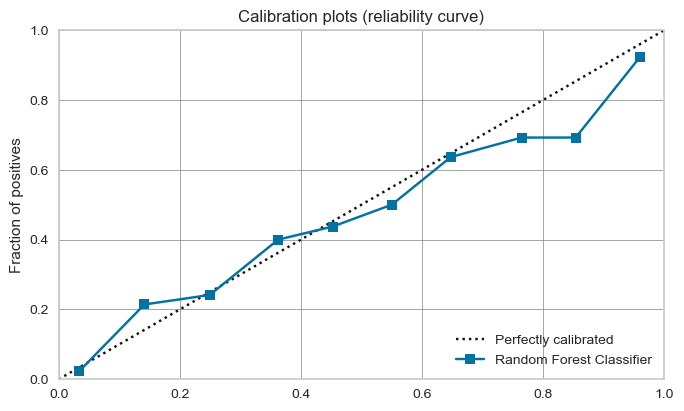

In [33]:
plot_model(calibrated_rf_isotonic, plot='calibration')